In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
import pathlib
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# https://arxiv.org/pdf/1704.02965.pdf

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
data_dir = "/content/gdrive/My Drive/CSE382M/Photos_Lite"
data_dir = pathlib.Path(data_dir)

Mounted at /content/gdrive


In [ ]:
# labels = os.listdir(data_dir)
# image_count = len(list(data_dir.glob('**/*.jpg')))
color = False

In [ ]:
batch_size = 32
img_height = 256
img_width = 256
img_channels = 1
color_mode = "grayscale"
if color:
  img_channels = 3
  color_mode = "rgb"
  

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  color_mode=color_mode,
  seed=1,
  image_size=(img_height, img_width),
  batch_size=None)

test_val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  color_mode=color_mode,
  seed=1,
  image_size=(img_height, img_width),
  batch_size=None)

X_test = []
Y_test = []

X_train = []
Y_train = []

X_val = []
Y_val = []

for i, tup in enumerate(test_val_ds):
  if i < len(test_val_ds)/2:
    X_test.append(tup[0].numpy())
    Y_test.append(tup[1].numpy())
  else:
    X_val.append(tup[0].numpy())
    Y_val.append(tup[1].numpy())

X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)
X_val = np.asarray(X_val)
Y_val = np.asarray(Y_val)
print(X_test.shape, Y_test.shape, X_val.shape, Y_val.shape)

for tup in train_ds:
  X_train.append(tup[0].numpy())
  Y_train.append(tup[1].numpy())

X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
print(X_train.shape, Y_train.shape)

# Model 1:
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)
# Model 2:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        vertical_flip=True,
        rotation_range=15,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_datagen.fit(X_train, seed=1)
# model 3 = increased patience on callback early stopping

test_datagen = ImageDataGenerator(rescale=1./255)



Found 2800 files belonging to 4 classes.
Using 1680 files for training.
Found 2800 files belonging to 4 classes.
Using 1120 files for validation.
(560, 256, 256, 1) (560,) (560, 256, 256, 1) (560,)
(1680, 256, 256, 1) (1680,)


In [ ]:
# val_ds = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="validation",
#   color_mode=color_mode,
#   seed=1,
#   image_size=(img_height, img_width),
#   batch_size=None)

# X_val = []
# Y_val = []

# for tup in val_ds:
#   X_val.append(tup[0])
#   Y_val.append(tup[1])

# test_ds = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="validation",
#   color_mode=color_mode,
#   seed=1,
#   image_size=(img_height, img_width),
#   batch_size=None)



In [ ]:
class_names = train_ds.class_names
print(class_names)

['baseball_diamond', 'basketball_court', 'lake', 'railway_station']


In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().shuffle(4500).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)
# layers.Rescaling(1./255, input_shape=(img_height, img_width, img_channels)),
model = Sequential([
  layers.InputLayer(input_shape=(img_height, img_width, img_channels)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
  layers.MaxPool2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
  layers.MaxPool2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
  layers.MaxPool2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  # layers.Dropout(0.2),
  layers.Dense(num_classes)
])

# TODO: 
# 2) increase network depth

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0

In [ ]:
def scheduler(epoch, lr):
  return lr
  if (epoch+1) % 15 == 0:
    return float(lr * 0.5)
  else:
    return lr
# simple early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=30)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)
epochs=500
history = model.fit(
  train_datagen.flow(X_train, Y_train, batch_size=batch_size),
  validation_data=test_datagen.flow(X_val, Y_val, 
                               batch_size=batch_size),
  epochs=epochs,
  callbacks=[es, mc, lrs]
)
# history = model.fit(
#   x=X_train,
#   y=Y_train,
#   batch_size=batch_size,
#   validation_split=0.2,
#   epochs=epochs,
#   callbacks=[es, mc, lrs]
# )
print(len(history.history['loss']))  

Epoch 1/500
53/53 [==============================] - ETA: 0s - loss: 1.9186 - accuracy: 0.3399
Epoch 1: val_accuracy improved from -inf to 0.37679, saving model to best_model.h5
53/53 [==============================] - 12s 166ms/step - loss: 1.9186 - accuracy: 0.3399 - val_loss: 1.6330 - val_accuracy: 0.3768 - lr: 0.0010
Epoch 2/500
53/53 [==============================] - ETA: 0s - loss: 1.4712 - accuracy: 0.4679
Epoch 2: val_accuracy improved from 0.37679 to 0.45714, saving model to best_model.h5
53/53 [==============================] - 9s 163ms/step - loss: 1.4712 - accuracy: 0.4679 - val_loss: 1.4098 - val_accuracy: 0.4571 - lr: 0.0010
Epoch 3/500
53/53 [==============================] - ETA: 0s - loss: 1.3194 - accuracy: 0.5012
Epoch 3: val_accuracy improved from 0.45714 to 0.55893, saving model to best_model.h5
53/53 [==============================] - 9s 163ms/step - loss: 1.3194 - accuracy: 0.5012 - val_loss: 1.2362 - val_accuracy: 0.5589 - lr: 0.0010
Epoch 4/500
53/53 [========

In [ ]:
# load the saved model
saved_model = tf.keras.models.load_model('best_model.h5')
train_acc = history.history['accuracy'][np.argmax(history.history['val_accuracy'])]
val_acc = np.max(history.history['val_accuracy'])
# evaluate the model
# _, train_acc = saved_model.evaluate(x=X_train,y=Y_train, verbose=0)
# for ele in train_ds:
#   print(ele[0].shape)
#   abc
# Y_preds = []
# Y_true = []
# for pair in test_ds:
#   pred = saved_model.predict(pair[0])
#   Y_preds.append(pred)
#   Y_true.append(pair[1])
# m = tf.keras.metrics.Accuracy()
# m.update_state(Y_true, Y_preds)
# test_acc = m.result().numpy()
_, test_acc = saved_model.evaluate(test_datagen.flow(X_test, Y_test),verbose=0)
print(' Train: %.3f, Val: %.3f,  Test: %.3f' % (train_acc,val_acc,test_acc))
saved_model.save("/content/gdrive/My Drive/CSE382M/model4")

 Train: 0.838, Val: 0.880,  Test: 0.854
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/CSE382M/model3/assets


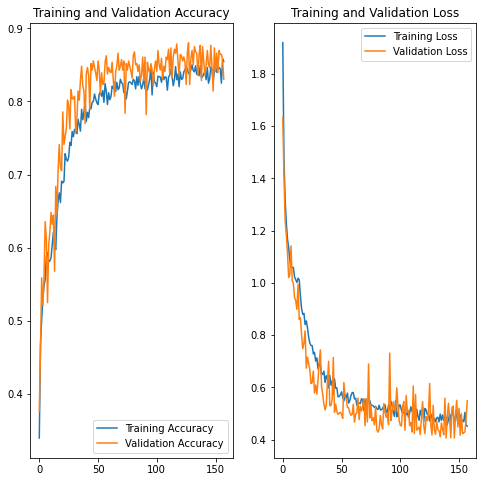

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("/content/gdrive/My Drive/CSE382M/model4/history.png")
plt.show()